# Classification on Thyroid Data
---

# Preprocessing

In [1]:
import platform
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score)
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline



from sklearn import datasets, metrics

## 1. Data loading

In [4]:
DATA = Path("/Users/malekbouzidi/Desktop/M1 Math&IA/Projet HoML")
assert DATA.exists()

# loading the data into a data frame
df = pd.read_csv(DATA / "thyroidDF.csv", low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9172 non-null   int64  
 1   sex                  8865 non-null   object 
 2   on_thyroxine         9172 non-null   object 
 3   query_on_thyroxine   9172 non-null   object 
 4   on_antithyroid_meds  9172 non-null   object 
 5   sick                 9172 non-null   object 
 6   pregnant             9172 non-null   object 
 7   thyroid_surgery      9172 non-null   object 
 8   I131_treatment       9172 non-null   object 
 9   query_hypothyroid    9172 non-null   object 
 10  query_hyperthyroid   9172 non-null   object 
 11  lithium              9172 non-null   object 
 12  goitre               9172 non-null   object 
 13  tumor                9172 non-null   object 
 14  hypopituitary        9172 non-null   object 
 15  psych                9172 non-null   o

## 2. Data preprocessing

In [5]:
# creating a copy of the dataframe so that the original data can remain intact
df_processing = df

# dropping columns indicating whether or not a certain value was measured
df_processing.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'referral_source', 'patient_id'],axis=1, inplace=True)

In [6]:
# associating diagnostic groups with target values 
diagnoses = {'-': 'negative',
             'A': 'hyperthyroid', 
             'B': 'hyperthyroid', 
             'C': 'hyperthyroid', 
             'D': 'hyperthyroid',
             'E': 'hypothyroid', 
             'F': 'hypothyroid', 
             'G': 'hypothyroid', 
             'H': 'hypothyroid'}

df_processing['target'] = df_processing['target'].map(diagnoses) # re-mapping

# dropping observations with 'target' null after re-mapping
df_processing.dropna(subset=['target'], inplace=True) 

df_processing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7546 entries, 0 to 9171
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7546 non-null   int64  
 1   sex                  7296 non-null   object 
 2   on_thyroxine         7546 non-null   object 
 3   query_on_thyroxine   7546 non-null   object 
 4   on_antithyroid_meds  7546 non-null   object 
 5   sick                 7546 non-null   object 
 6   pregnant             7546 non-null   object 
 7   thyroid_surgery      7546 non-null   object 
 8   I131_treatment       7546 non-null   object 
 9   query_hypothyroid    7546 non-null   object 
 10  query_hyperthyroid   7546 non-null   object 
 11  lithium              7546 non-null   object 
 12  goitre               7546 non-null   object 
 13  tumor                7546 non-null   object 
 14  hypopituitary        7546 non-null   object 
 15  psych                7546 non-null   object

In [7]:
df_processing.groupby('target').count()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG
target,,,,,,,,,,,,,,,,,,,,,
hyperthyroid,182,167,182,182,182,182,182,182,182,182,...,182,182,182,182,150,146,182,176,176,3
hypothyroid,593,570,593,593,593,593,593,593,593,593,...,593,593,593,593,592,429,584,549,550,5
negative,6771,6559,6771,6771,6771,6771,6771,6771,6771,6771,...,6771,6771,6771,6771,6082,4762,6426,6145,6151,251


In [8]:
df_processing.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,7546.000000,6824.000000,5337.000000,7192.000000,6870.000000,6877.000000,259.000000
mean,78.013782,5.421753,2.020935,105.203373,0.967322,110.571745,22.955019
std,1305.258137,26.080471,0.809865,32.606462,0.162315,36.600867,6.088392
min,1.000000,0.005000,0.050000,2.000000,0.190000,1.400000,0.100000
25%,37.000000,0.570000,1.600000,87.000000,0.870000,93.000000,20.000000
50%,55.000000,1.400000,2.000000,103.000000,0.960000,108.000000,23.000000
75%,67.000000,2.700000,2.300000,121.000000,1.060000,125.000000,27.000000
max,65526.000000,530.000000,18.000000,430.000000,2.120000,839.000000,45.000000


There is clearly something wrong with the age variable values since the maximum is 65,526. In order to properly visualise the data, age values that are higher than 100 are replaced with null values.

In [9]:
df_processing.loc[df_processing['age'] > 100, 'age'] = None

## 3. Exploratory analysis

/var/folders/lb/mzhypv054bn5nvqs9tp_4l4w0000gn/T/ipykernel_79772/3735235503.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x=df_processing.target, y=df_processing.TSH, linewidth=0.6, jitter= 0.3, ax=axes[0, 0], palette= 'tab10')
/var/folders/lb/mzhypv054bn5nvqs9tp_4l4w0000gn/T/ipykernel_79772/3735235503.py:9: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x=df_processing.target, y=df_processing.T3, linewidth=0.6, jitter= 0.3, ax=axes[0, 1], palette= 'tab10')
/var/folders/lb/mzhypv054bn5nvqs9tp_4l4w0000gn/T/ipykernel_79772/3735235503.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x=df_processing.target, y=df_processing.TT4, linewidth=0.6, jitter= 0.3, ax=axes[1, 0], palette= 'tab10')
/var/folders/lb/mzhypv054bn5nvqs9tp_4l4w0000gn/T/ipykernel_79772/3735235503.py:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x

<Axes: xlabel='target', ylabel='TBG'>

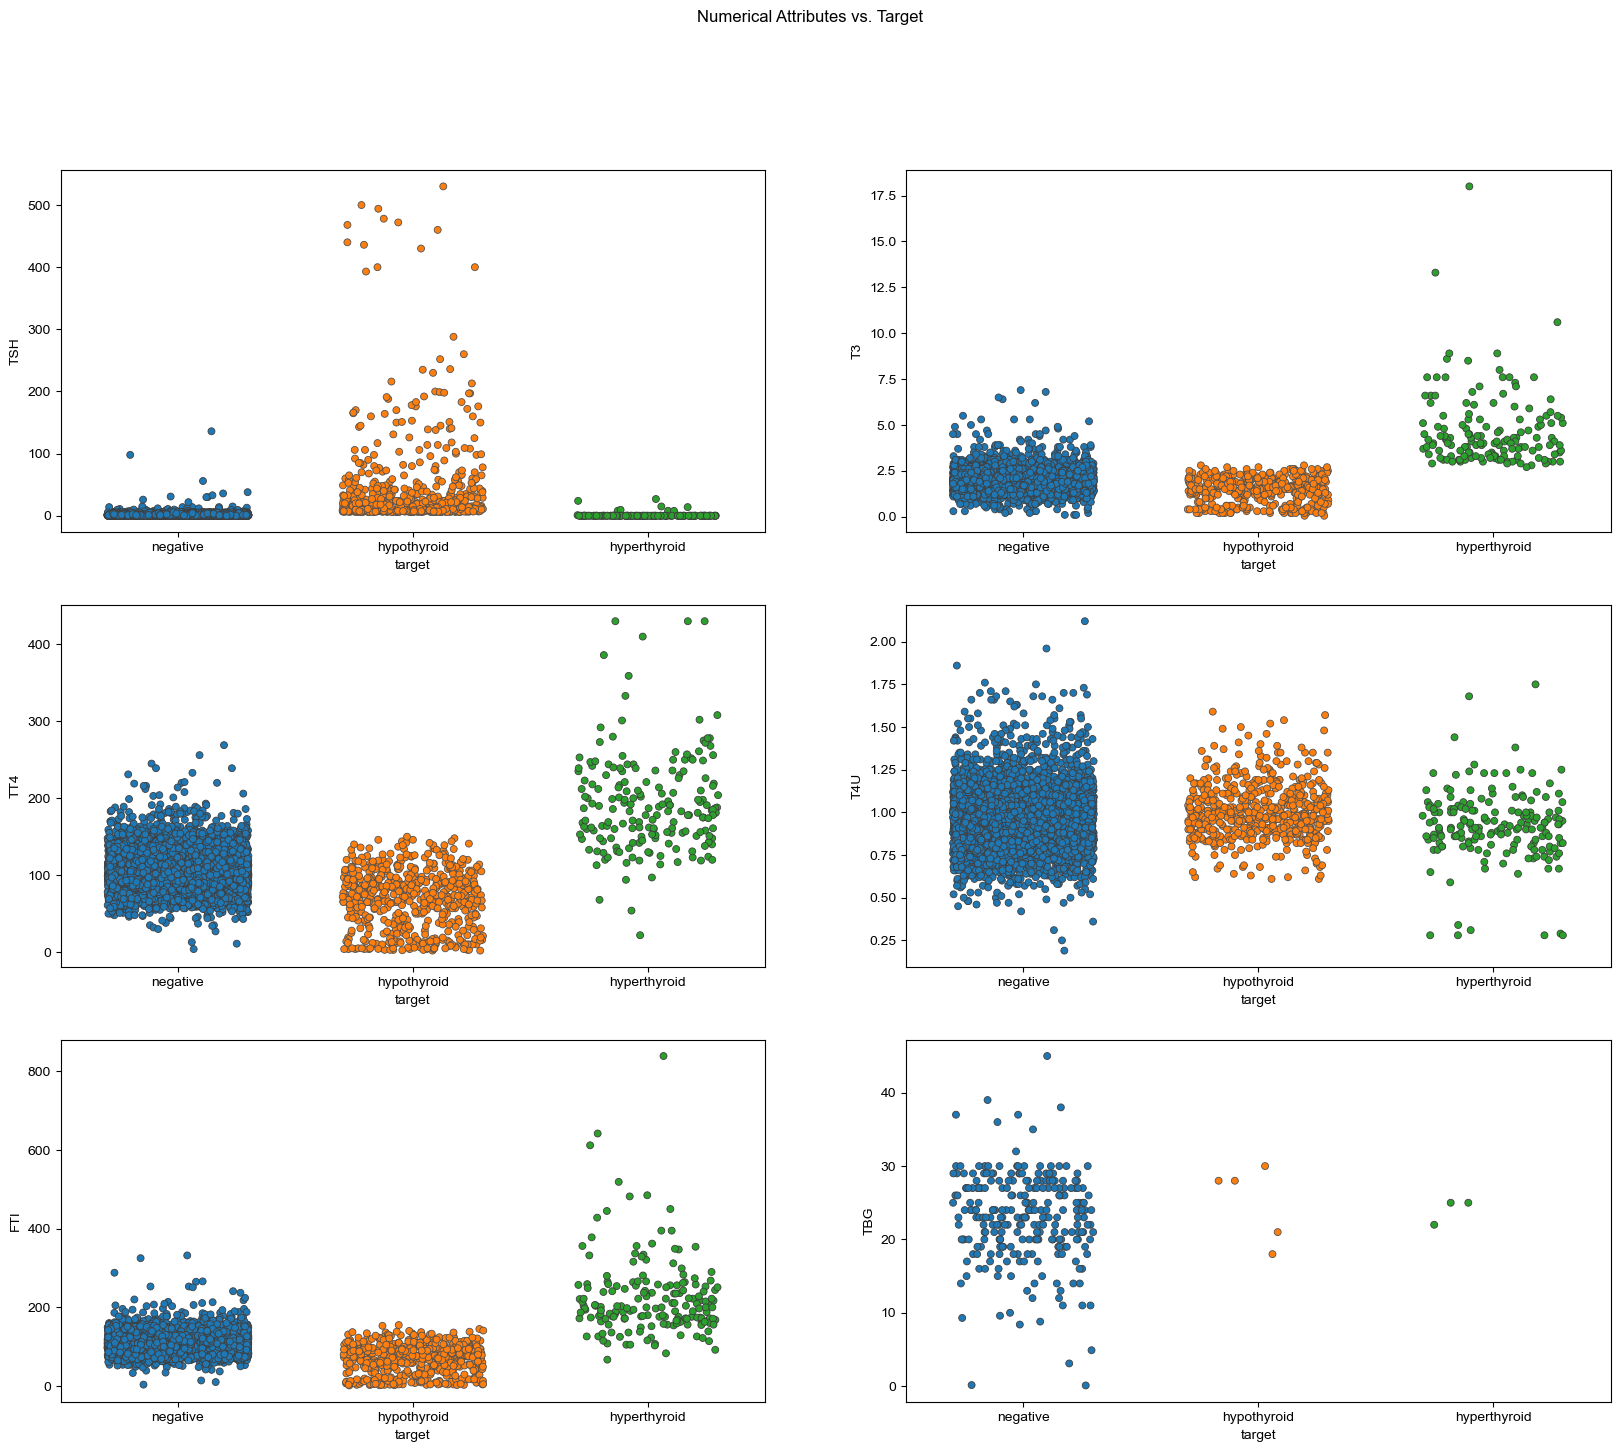

In [10]:
# setting up grid for multiple seaborn plots
fig, axes = plt.subplots(3,2,figsize=(20,16))
fig.suptitle('Numerical Attributes vs. Target')
sns.set_style('whitegrid');

# TSH vs. 'target'
sns.stripplot(x=df_processing.target, y=df_processing.TSH, linewidth=0.6, jitter= 0.3, ax=axes[0, 0], palette= 'tab10')
# T3 vs. 'target'
sns.stripplot(x=df_processing.target, y=df_processing.T3, linewidth=0.6, jitter= 0.3, ax=axes[0, 1], palette= 'tab10')
# TT4 vs. 'target'
sns.stripplot(x=df_processing.target, y=df_processing.TT4, linewidth=0.6, jitter= 0.3, ax=axes[1, 0], palette= 'tab10')
# T4U vs. 'target'
sns.stripplot(x=df_processing.target, y=df_processing.T4U, linewidth=0.6, jitter= 0.3, ax=axes[1, 1], palette= 'tab10')
# FTI vs. 'target'
sns.stripplot(x=df_processing.target, y=df_processing.FTI, linewidth=0.6, jitter= 0.3, ax=axes[2, 0], palette= 'tab10')
# TBG vs. 'target'
sns.stripplot(x=df_processing.target, y=df_processing.TBG, linewidth=0.6, jitter= 0.3, ax=axes[2, 1], palette= 'tab10')

One can assume that FTI, T3, and TT4 will be good feature additions to the model.


TSH looks like it might be good as well but one must note the presence of several outliers for the target value hyperthyroid.


TBG looks like it is missing a significant amount of data since its plot presents very few points compared to the others.


It seems that there are many severe outliers in the data. However, following research done about the significance of these values, it is concluded that this type of variance is normal within this context. Furthermore, it is to be expected, especially when dealing with individuals who will present abnormal values in these hormone levels given their medical conditions.

/Users/malekbouzidi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


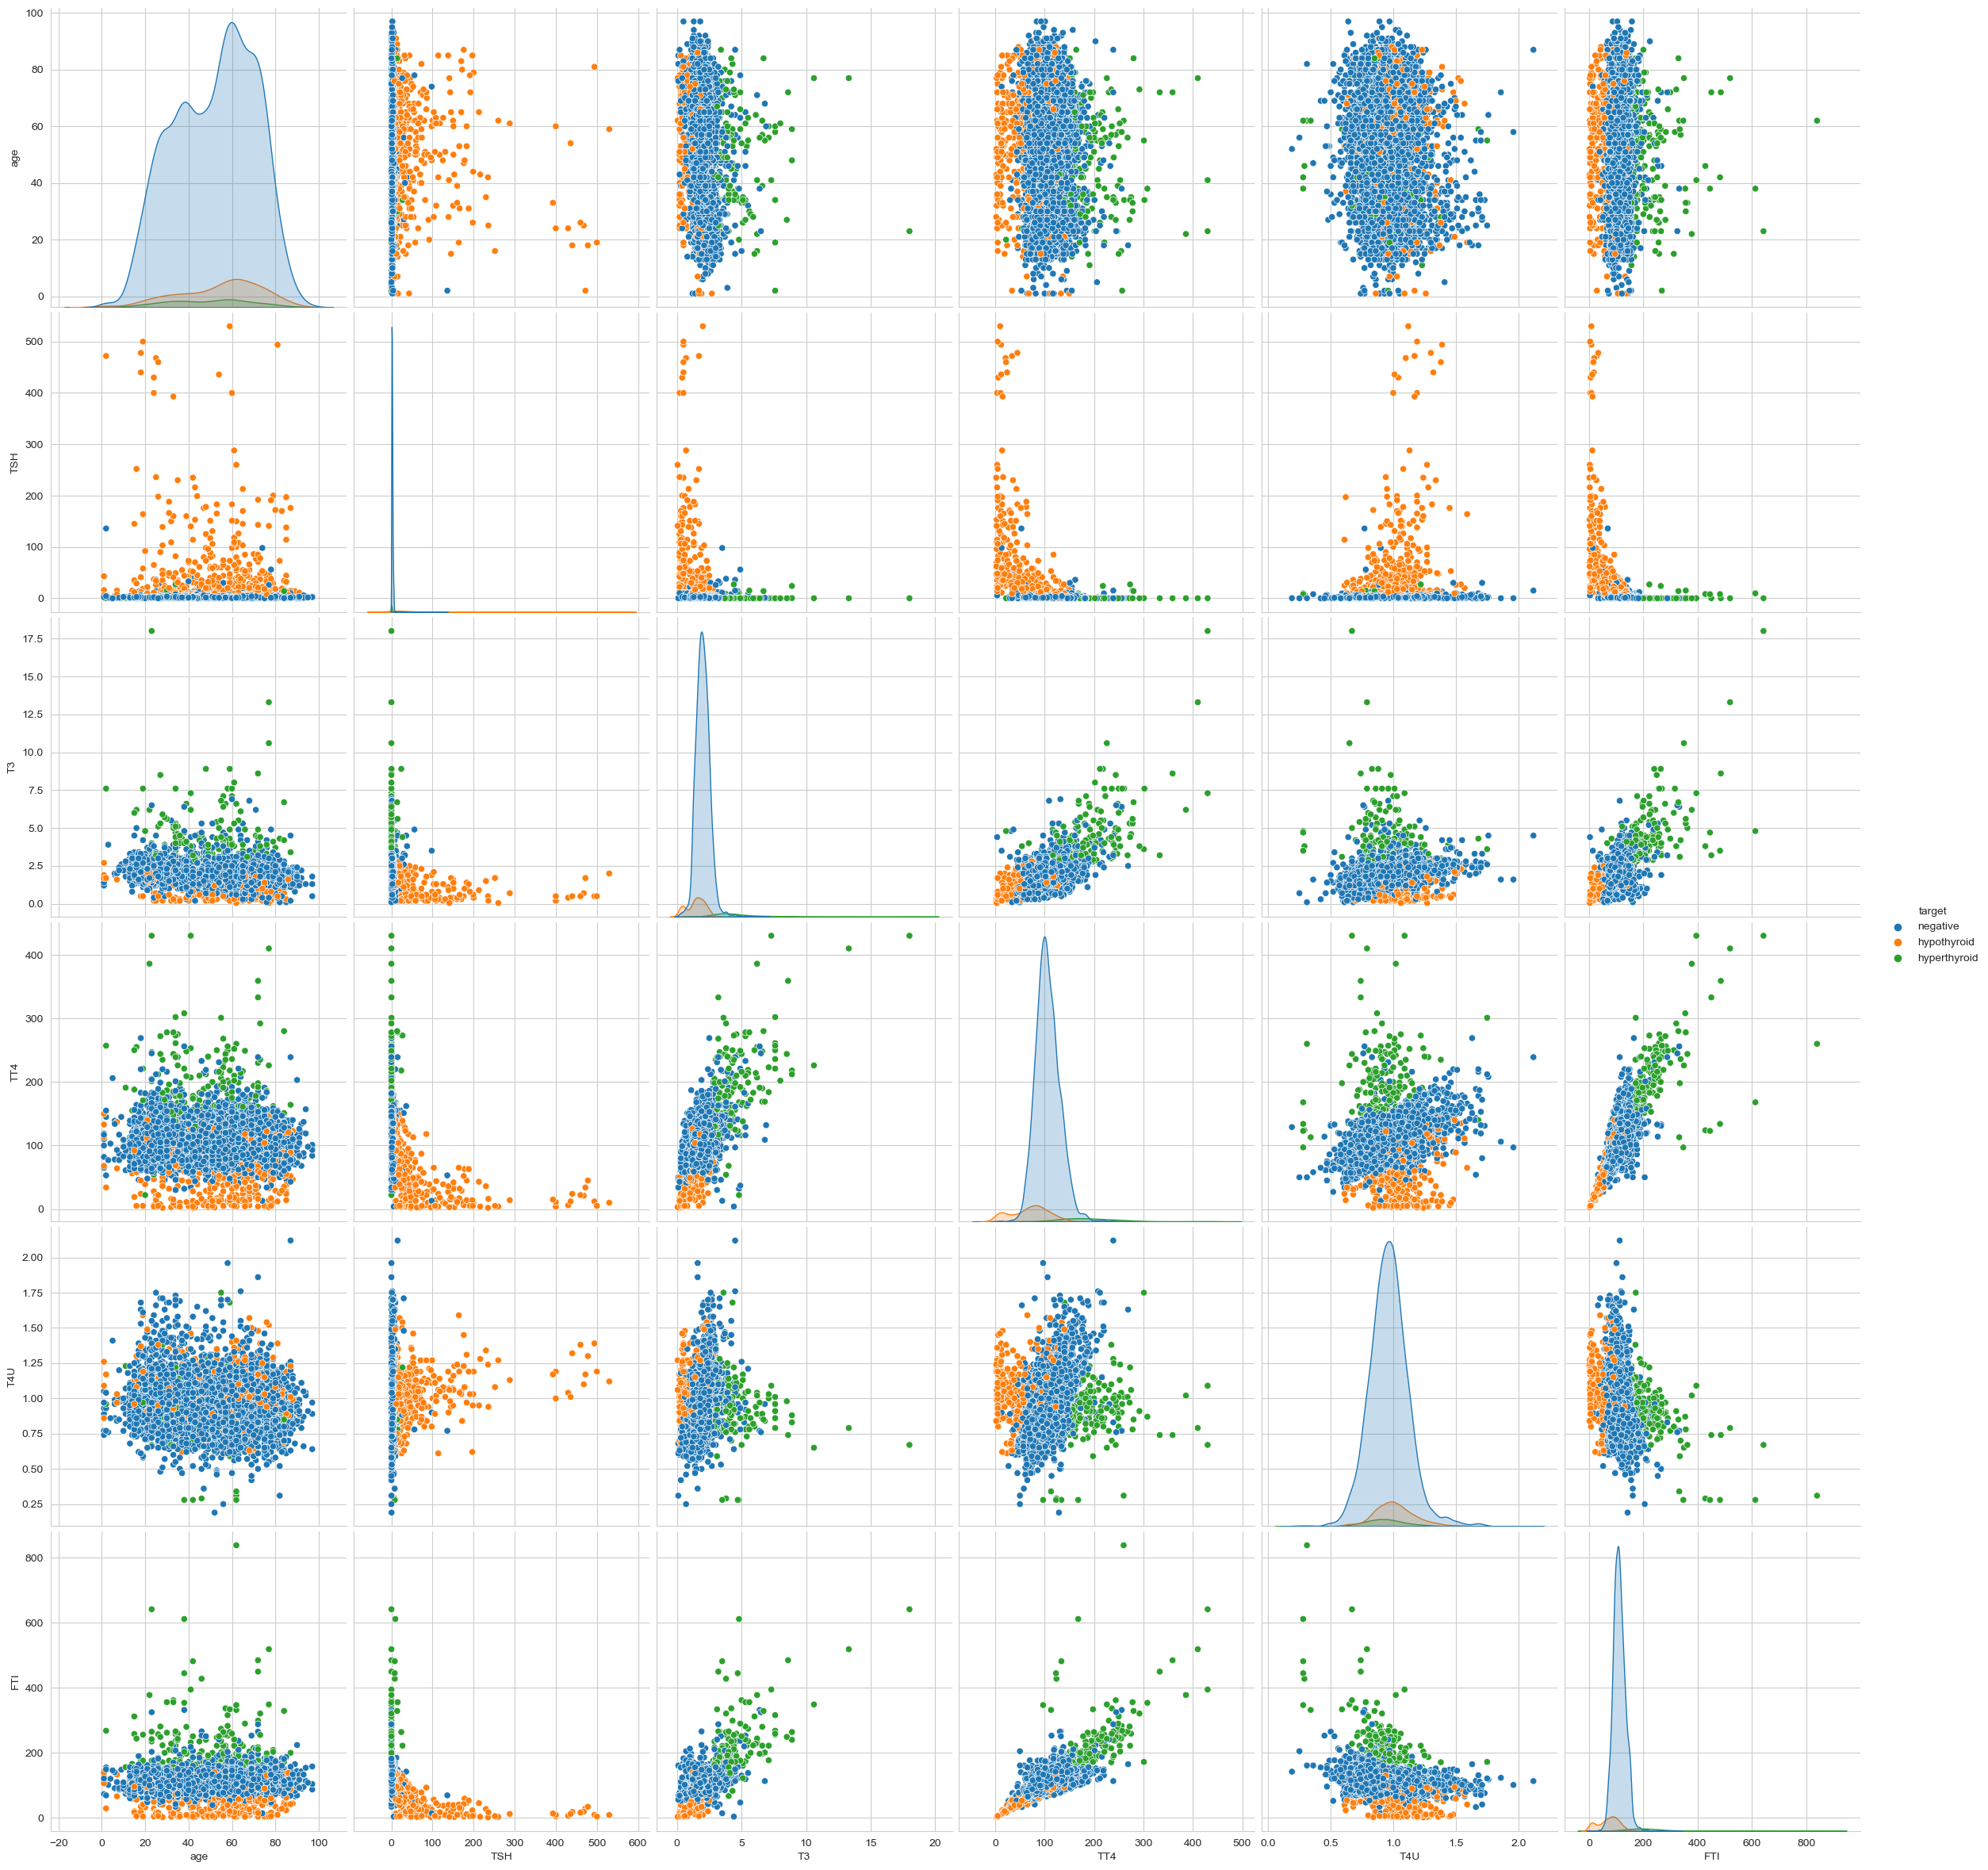

In [11]:
numericalDF = df_processing[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'target']].copy()
sns.set_style('whitegrid');
sns.pairplot(numericalDF, hue='target', height=4, palette= 'tab10');
plt.show()

We can see that for in some of the comparisons, there are nice clusters that form. 
This is encouraging since it indicates that those variables do a good job at separating out each of our target classes, especially in the graphs comparing:

1. FTI vs T3
2. FTI vs T4U
3. FTI vs age
4. T4U vs TT4
5. TT4 vs age
6. TT4 vs T3

## 4. Data cleaning: 
### I. Dealing with missing values

When dealing with missing values, several methods can be employed depending on the data at hand. The first step is to check how many missing values there are in each column.

In [12]:
# Calculating the percentage of missing values in each column
missing_percentage = (df_processing.isnull().sum() / len(df_processing)) * 100

# Creating a new DataFrame with missing percentage information
missing_df = pd.DataFrame({'Column': missing_percentage.index, 'Missing Percentage': missing_percentage.values})

missing_df

,Column,Missing Percentage
0,age,0.053008
1,sex,3.313014
2,on_thyroxine,0.000000
3,query_on_thyroxine,0.000000
4,on_antithyroid_meds,0.000000
5,sick,0.000000
6,pregnant,0.000000
7,thyroid_surgery,0.000000
8,I131_treatment,0.000000
9,query_hypothyroid,0.000000


In [13]:
# TBG is missing over 96% of its values; it is dropped
df_processing.drop(['TBG'], axis=1, inplace=True)

# age is missing a few values (~ 0.05%)
# this could partially be due to the step in which we replaced the absurd numbers with NaN values
df_processing.dropna(subset=['age'], inplace=True)

df_processing.drop(['hypopituitary'], axis=1, inplace=True)

df_processing['sex'] = np.where((df_processing['sex'].isnull()) & (df_processing.pregnant == 't'), 'F', df_processing['sex'])
df_processing.dropna(subset=['sex'], inplace=True)

df_cleaned = df_processing.dropna()

In [14]:
# remove rows with 3 or more missing values
df_cleaned['n_missing'] = df_cleaned.isnull().sum(axis=1)

df_cleaned.drop(df_cleaned.index[df_cleaned['n_missing'] > 2], inplace=True)

# remove n_missing column
df_cleaned.drop(['n_missing'], axis=1, inplace=True)

/var/folders/lb/mzhypv054bn5nvqs9tp_4l4w0000gn/T/ipykernel_79772/2580352667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['n_missing'] = df_cleaned.isnull().sum(axis=1)
/var/folders/lb/mzhypv054bn5nvqs9tp_4l4w0000gn/T/ipykernel_79772/2580352667.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(df_cleaned.index[df_cleaned['n_missing'] > 2], inplace=True)
/var/folders/lb/mzhypv054bn5nvqs9tp_4l4w0000gn/T/ipykernel_79772/2580352667.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

In [15]:
column_names_list = df_cleaned.columns.tolist()
column_names_list

['age',
 'sex',
 'on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_meds',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'psych',
 'TSH',
 'T3',
 'TT4',
 'T4U',
 'FTI',
 'target']

### II. Encoding of categorical and boolean features

In [16]:
# DataFrame contains non-numerical and numerical variables
# this function allows the encoding of non-numerical variables into numerical labels
def label_encode_dataframe(dataframe, columns):
    label_encoder_info = {}  # Dictionary to store encoding information
    
    for column in columns:
        if column in dataframe.columns:  # Check if the column exists
            label_encoder = LabelEncoder()
            encoded_column_name = column + '_encoded'
            dataframe[encoded_column_name] = label_encoder.fit_transform(dataframe[column])
            
            # Store encoding information in the dictionary
            label_encoder_info[column] = {
                'encoder': label_encoder,
                'encoded_column_name': encoded_column_name,
                'encoding_mapping': dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
            }
        else:
            print(f"Warning: Column '{column}' not found in the DataFrame. Skipping.")

    return dataframe, label_encoder_info

# Specifying the non-numerical columns to be label-encoded
non_numerical_columns = ['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds', 'sick', 
                         'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 
                         'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'psych', 'target']

# Apply label encoding and get the encoding information
df_encoded, encoding_info = label_encode_dataframe(df_cleaned, non_numerical_columns)

df_encoded.drop(['sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'psych', 'target'], axis=1, inplace=True)


df_encoded.columns = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'sex',
       'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant',
       'thyroid_surgery', 'I131_treatment',
       'query_hypothyroid', 'query_hyperthyroid',
       'lithium', 'goitre', 'tumor', 'psych',
       'target']

# Display the encoding information
for column, info in encoding_info.items():
    print(f"\nEncoding information for '{column}':")
    print(f"Encoded column name: {info['encoded_column_name']}")
    print("Encoding mapping:")
    for original_value, encoded_value in info['encoding_mapping'].items():
        print(f"  {original_value} -> {encoded_value}")


Encoding information for 'sex':
Encoded column name: sex_encoded
Encoding mapping:
  F -> 0
  M -> 1

Encoding information for 'on_thyroxine':
Encoded column name: on_thyroxine_encoded
Encoding mapping:
  f -> 0
  t -> 1

Encoding information for 'query_on_thyroxine':
Encoded column name: query_on_thyroxine_encoded
Encoding mapping:
  f -> 0
  t -> 1

Encoding information for 'on_antithyroid_meds':
Encoded column name: on_antithyroid_meds_encoded
Encoding mapping:
  f -> 0
  t -> 1

Encoding information for 'sick':
Encoded column name: sick_encoded
Encoding mapping:
  f -> 0
  t -> 1

Encoding information for 'pregnant':
Encoded column name: pregnant_encoded
Encoding mapping:
  f -> 0
  t -> 1

Encoding information for 'thyroid_surgery':
Encoded column name: thyroid_surgery_encoded
Encoding mapping:
  f -> 0
  t -> 1

Encoding information for 'I131_treatment':
Encoded column name: I131_treatment_encoded
Encoding mapping:
  f -> 0
  t -> 1

Encoding information for 'query_hypothyroid':

/var/folders/lb/mzhypv054bn5nvqs9tp_4l4w0000gn/T/ipykernel_79772/2808658544.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[encoded_column_name] = label_encoder.fit_transform(dataframe[column])
/var/folders/lb/mzhypv054bn5nvqs9tp_4l4w0000gn/T/ipykernel_79772/2808658544.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[encoded_column_name] = label_encoder.fit_transform(dataframe[column])
/var/folders/lb/mzhypv054bn5nvqs9tp_4l4w0000gn/T/ipykernel_79772/2808658544.py:10: SettingWith

### III. Further exploration: correlation matrix/PCA

<Axes: >

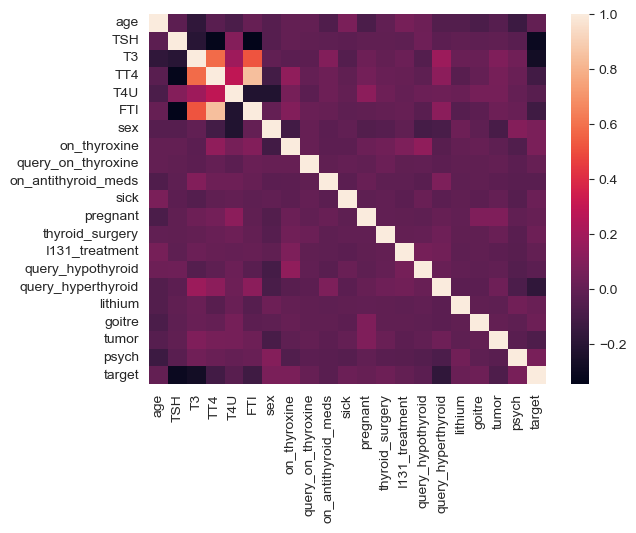

In [17]:
sns.heatmap(df_encoded.corr())

Most of the correlation coefficients are smaller than 0.3; this indicates that PCA would not be helpful in dealing with this specific data set.

### IV. Scaling the data

Numerous machine learning algorithms, like Support Vector Machines, k-Nearest Neighbors, and Neural Networks, exhibit sensitivity to the scaling of input features. When features vary in scale, there is a risk that the algorithm may disproportionately emphasize features with larger scales, introducing bias and potentially distorting the results. Scaling the data is thus necessary in order to improve the accuracy of the model.

In [18]:
# Scaling the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_encoded)

df_scaled = pd.DataFrame(df_scaled); df_scaled.columns = column_names_list

df_scaled[df_scaled == 1] = 2
df_scaled[df_scaled == 0.5] = 1

df_scaled['target'] = df_scaled['target'].astype(int)

df_scaled

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,lithium,goitre,tumor,psych,TSH,T3,TT4,T4U,FTI,target
0,0.364583,0.002821,0.130919,0.205607,0.433155,0.130503,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2
1,0.406250,0.002255,0.125348,0.238318,0.443850,0.147674,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.406250,0.011123,0.114206,0.200935,0.315508,0.161723,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.791667,0.000085,0.130919,0.245327,0.470588,0.146113,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.520833,0.000085,0.114206,0.212617,0.331551,0.163284,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4652,0.666667,0.001368,0.097493,0.193925,0.347594,0.144552,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4653,0.666667,0.007726,0.114206,0.310748,0.502674,0.174212,0.0,2.0,0.0,0.0,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2
4654,0.760417,0.099992,0.052925,0.109813,0.534759,0.058695,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4655,0.427083,0.004330,0.069638,0.133178,0.256684,0.124259,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2


# Training

## 1. Selection of training and test set

In [19]:
df_scaled_subset = df_scaled[df_scaled['target'] == 2].sample(frac=0.1, random_state=42)

In [20]:
from sklearn import model_selection

y = df_scaled['target']
train_xs, test_xs, train_ys, test_ys = model_selection.train_test_split(
    df_scaled, y, random_state=1
)

print(train_ys.shape, train_xs.shape)
print(test_ys.shape, test_xs.shape)

(3492,) (3492, 21)
(1165,) (1165, 21)


In [21]:
train_xs = train_xs.drop('target', axis=1)

train_xs.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,psych,TSH,T3,TT4,T4U,FTI
2192,0.385417,0.000057,0.097493,0.299065,0.331551,0.231970,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2161,0.812500,0.006594,0.086351,0.207944,0.395722,0.139869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1028,0.562500,0.000179,0.097493,0.235981,0.352941,0.174212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4401,0.302083,0.001481,0.097493,0.184579,0.326203,0.144552,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
498,0.166667,0.003953,0.097493,0.259346,0.417112,0.167968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0


In [22]:
test_xs = test_xs.drop('target', axis=1)

test_xs.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,psych,TSH,T3,TT4,T4U,FTI
3123,0.562500,0.001066,0.075209,0.170561,0.251337,0.160162,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
157,0.854167,0.000368,0.091922,0.179907,0.294118,0.152357,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3525,0.583333,0.020745,0.114206,0.170561,0.406417,0.113331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3716,0.781250,0.002066,0.097493,0.292056,0.550802,0.152357,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1758,0.656250,0.016783,0.064067,0.151869,0.267380,0.136747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


## 2. Fitting the models

### Model 1: Support Vector Machines

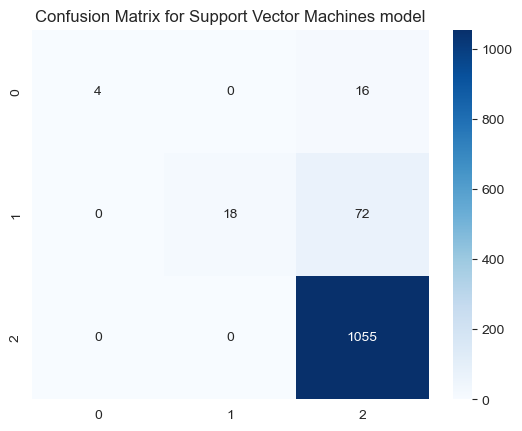

In [23]:
# 1. Model choice (import)
from sklearn.svm import SVC

# 2. Instantiation
model_1 = SVC()

# 3. Learn (fit) the model
model_1.fit(train_xs, train_ys)

# 4. Predict on new data
pred_ys_1 = model_1.predict(test_xs)

# 5. Accuracy score
score_1 = metrics.accuracy_score(test_ys, pred_ys_1)

# Confusion matrix
cm = metrics.confusion_matrix(test_ys, pred_ys_1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix for Support Vector Machines model")
plt.show()

### Model 2: Logistic Regression

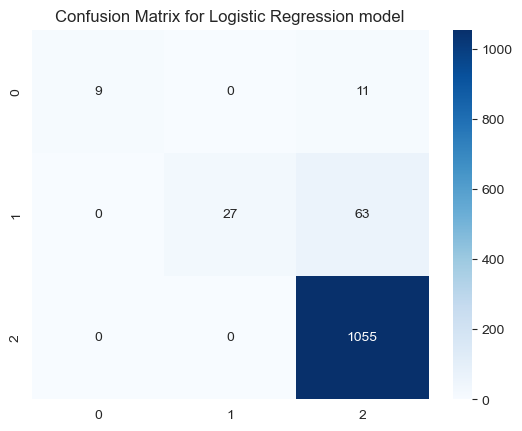

In [29]:
# 1. Model choice (import)
from sklearn.linear_model import LogisticRegression

# 2. Instantiation
model_2 = LogisticRegression(max_iter=2000)

# 3. Learn (fit) the model
model_2.fit(train_xs, train_ys)

# 4. Predict on new data
pred_ys_2 = model_2.predict(test_xs)

# 5. Accuracy score
score_2 = metrics.accuracy_score(test_ys, pred_ys_2)

# Confusion matrix
cm = metrics.confusion_matrix(test_ys, pred_ys_2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix for Logistic Regression model")
plt.show()

### Model 3: Gaussian

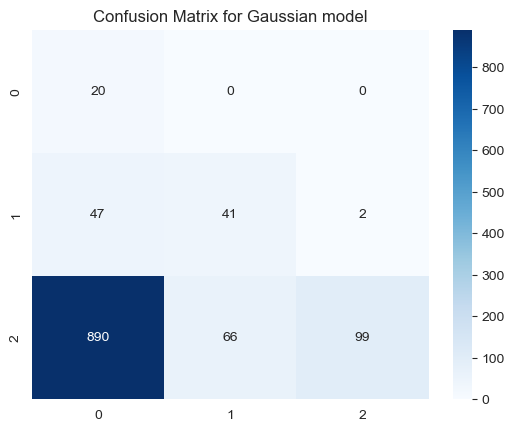

In [24]:
# 1. Model choice (import)
from sklearn.naive_bayes import GaussianNB

# 2. Instantiation
model_3 = GaussianNB()

# 3. Learn (fit) the model
model_3.fit(train_xs, train_ys)

# 4. Predict on new data
pred_ys_3 = model_3.predict(test_xs)

# 5. Accuracy score
score_3 = metrics.accuracy_score(test_ys, pred_ys_3)

# Confusion matrix
cm = metrics.confusion_matrix(test_ys, pred_ys_3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix for Gaussian model")
plt.show()

### Model 4: Decision Trees


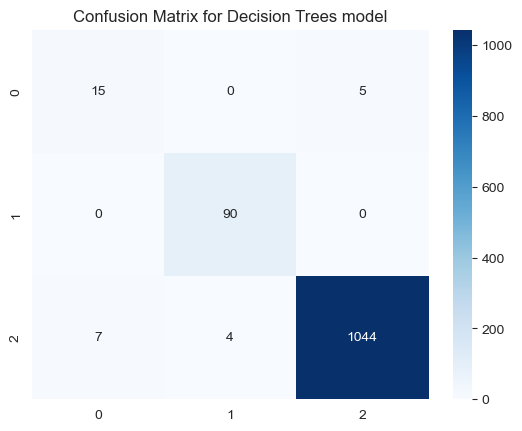

In [25]:
# 1. Model choice (import)
from sklearn.tree import DecisionTreeClassifier

# 2. Instantiation
model_4 = DecisionTreeClassifier()

# 3. Learn (fit) the model
model_4.fit(train_xs, train_ys)

# 4. Predict on new data
pred_ys_4 = model_4.predict(test_xs)

# 5. Accuracy score
score_4 = metrics.accuracy_score(test_ys, pred_ys_4)

# Confusion matrix
cm = metrics.confusion_matrix(test_ys, pred_ys_4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix for Decision Trees model")
plt.show()

### Model 5: Random Forest

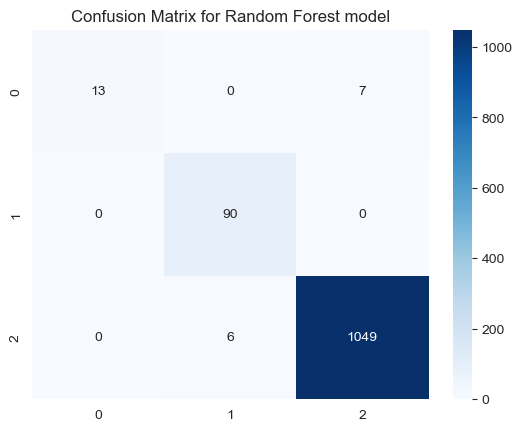

In [26]:
# 1. Model choice (import)
from sklearn.ensemble import RandomForestClassifier

# 2. Instantiation
model_5 = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

# 3. Learn (fit) the model
model_5.fit(train_xs, train_ys)

# 4. Predict on new data
pred_ys_5 = model_5.predict(test_xs)

# 5. Accuracy score
score_5 = metrics.accuracy_score(test_ys, pred_ys_5)

# Confusion matrix
cm = metrics.confusion_matrix(test_ys, pred_ys_5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix for Random Forest model")
plt.show()

### Model 6: k-Nearest Neighbors

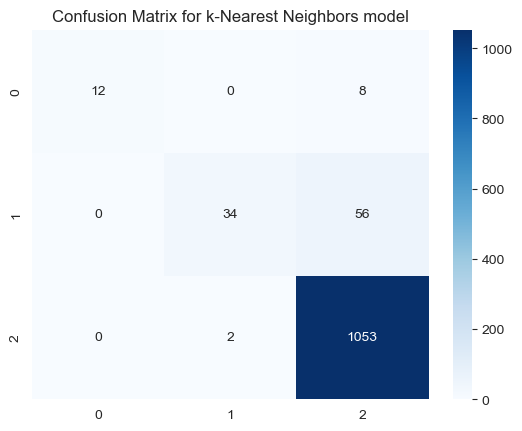

In [27]:
# 1. Model choice (import)
from sklearn.neighbors import KNeighborsClassifier

train_xs = np.array(train_xs)
test_xs = np.array(test_xs)
train_ys = np.array(train_ys)
test_ys = np.array(test_ys)

# 2. Instantiation
model_6 = KNeighborsClassifier()

# 3. Learn (fit) the model
model_6.fit(train_xs, train_ys)

# 4. Predict on new data
pred_ys_6 = model_6.predict(test_xs)

# 5. Accuracy score
score_6 = metrics.accuracy_score(test_ys, pred_ys_6)

# Confusion matrix
cm = metrics.confusion_matrix(test_ys, pred_ys_6)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix for k-Nearest Neighbors model")
plt.show()

# Evaluation

## 1. Evaluation metrics

In order to evaluate the fitted models, the following three metrics are employed:

1. **Accuracy:** represents *the ratio of correctly predicted instances to the total number of instances*. This means that it measures the overall correctness of the model across all classes. It is important to note that it may not be suitable when classes are imbalanced.


2. **F-score:** is a metric that combines precision and sensitivity, providing a balance between false positives and false negatives. Consequently, it indicates the *model's ability to balance precision and recall across all classes* which renders it useful when there is an uneven distribution of classes.


3. **Cross Validation Score:** is the *average performance of the model evaluated across different subsets of the data* (folds) during cross-validation. It provides an estimate of the model's generalization performance on unseen data. It helps assess the model's robustness and its ability to perform consistently on different subsets of the dataset.

In [30]:
from sklearn.metrics import f1_score
import warnings

warnings.filterwarnings("ignore") 

models = {
    'Support Vector Machines': model_1,
    'Logistic Regression': model_2,
    'Gaussian': model_3,
    'Decision Trees': model_4,
    'Random Forest': model_5,
    'k-Nearest Neighbors': model_6
    }
for model_name, model in models.items():
    
    print(f"\033[1;34m{model_name}:\033[0m")

    y_pred = model.predict(test_xs)
    
    # Accuracy score
    accuracy = metrics.accuracy_score(test_ys, y_pred)
    print(f"Accuracy: {accuracy: .4f}")
    
    # F-score
    f1 = f1_score(test_ys, y_pred, average='weighted')
    print(f"F-score: {f1: .4f}")
    
    # Cross validation score
    cross_val = cross_val_score(model, train_xs, train_ys, cv=5).mean()
    print(f"Cross Validation Score: {cross_val: .4f}")

    print('\n')
    
warnings.filterwarnings("default")

Support Vector Machines:
Accuracy:  0.9245
F-score:  0.9008
Cross Validation Score:  0.9052


Logistic Regression:
Accuracy:  0.9365
F-score:  0.9212
Cross Validation Score:  0.9172


Gaussian:
Accuracy:  0.1373
F-score:  0.1880
Cross Validation Score:  0.1647


Decision Trees:
Accuracy:  0.9863
F-score:  0.9865
Cross Validation Score:  0.9857


Random Forest:
Accuracy:  0.9888
F-score:  0.9883
Cross Validation Score:  0.9848


k-Nearest Neighbors:
Accuracy:  0.9433
F-score:  0.9326
Cross Validation Score:  0.9267




The three best models seem to be Random Forest, Decision Trees, and Logistic Regression. These three models have the highest scores across multiple metrics, indicating strong performance. 

However, the Random Forest model stands out as it has the highest accuracy, F-score, and cross-validation score among the models listed. Therefore **the Random Forest model seems to be the most suitable for the task at hand**.

## 2. Fine-tuning

The 3 best models are retained and fine-tuned in this section.

Since the hyperparameter space is relatively small and we would like to find the exact combination that maximizes performance, we opted for a Grid Search instead of a Randomized Search.

In [33]:
from sklearn.model_selection import GridSearchCV


# Create a dictionary of models
models = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}


# Define hyperparameter grids for each model
param_grids = {
    'DecisionTree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10, 15]},
    'RandomForest': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]},
    'KNN': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
}

# Fine-tune hyperparameters for each model using GridSearchCV
best_models = {}

for model_name, model in models.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(xps, yps)

    best_models[model_name] = grid_search.best_estimator_

    # Store the best hyperparameters for each model
    best_models[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }
    
    print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}\n")

# Access the best model and make predictions
for model_name, best_model_info in best_models.items():
    best_model = best_model_info['best_estimator']
    best_params = best_model_info['best_params']
    best_score = best_model_info['best_score']
    
    predictions = best_model.predict(test_xs)

NameError: name 'xps' is not defined

After fine-tuning, one can see that both Decision Tree and Random Forest have nearly identical cross-validation scores. Subsequently, additional factors, such as interpretability, training and prediction speed, and the nature of your specific problem, have to be considered to make the final decision:

1. Decision Tree:

**Advantages:** Easy to comprehend and interpret, typically quicker to train and predict in comparison to Random Forest.

**Drawbacks:** *Susceptible to overfitting*, less resilient compared to Random Forest.

2. Random Forest:

**Advantages:** Collections of decision trees often yield improved generalization performance, are *resistant to overfitting*, and handle a broader range of data effectively.

**Drawbacks:** May entail computational expense and could be more challenging to interpret than an individual decision tree.

Random Forest seems to be more robust than Decision Trees; thus, Random Forest is the chosen model.

## 3. Training a final model based on findings

In [ ]:
# Training a fine-tuned Random Forest model
model = RandomForestClassifier(n_estimators=50, max_depth=20, max_leaf_nodes=16, n_jobs=-1)

model.fit(train_xs, train_ys)

pred_ys = model.predict(test_xs)

score = metrics.accuracy_score(test_ys, pred_ys)

# Confusion matrix
cm = metrics.confusion_matrix(test_ys, pred_ys)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix for fine-tuned Random Forest model")
plt.show()

print(f"The accuracy score for this model is equal to: {score: .4f}")
print(f"The generalization error for this model is equal to: {1 - score: .4f}")

# Conclusion

In conclusion, this project aimed to classify patients with various thyroid-related diseases based on age, sex, and medical information, including thyroid hormone levels in blood. The dataset, obtained from the UCI machine learning repository, originally contained information on 9172 unique patients with 20 possible medical diagnoses. The study focused on three specific types: negative, hypothyroid, and hyperthyroid.


The preprocessing stage involved loading the data, handling missing values, encoding categorical features, and exploring the relationships between numerical attributes and the target variable. Following that, an exploratory analysis revealed potential features (such as FTI, T3, and TT4) that could be valuable for model training. Data cleaning addressed outliers, missing values, and encoding of categorical features.


Six machine learning models—Support Vector Machines, Logistic Regression, Gaussian, Decision Trees, Random Forest, and k-Nearest Neighbors—were trained and evaluated. Among them, Random Forest emerged as the most promising model, showcasing the highest accuracy, F-score, and cross-validation scores. Further fine-tuning using GridSearchCV was performed on Decision Trees and Random Forest, with both models demonstrating comparable cross-validation scores. Ultimately, Random Forest was selected for its overall robustness.


The final fine-tuned Random Forest model exhibited strong performance, as indicated by a high accuracy score. The confusion matrix illustrated the model's ability to correctly classify instances across different thyroid disease classes. The generalization error was also calculated to assess the model's performance on unseen data.
Every feature, such as age, sex, and different thyroid hormone levels, was included in the classification to conduct a thorough analysis - especially since their was little to no correlation between them.


In summary, the Random Forest model, after careful preprocessing and fine-tuning, proved to be effective in classifying thyroid diseases based on patient data. This project underscores the importance of comprehensive data analysis, thoughtful feature selection, and model evaluation in building a robust machine learning solution for medical diagnosis. 